In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import librosa
import matplotlib.pyplot as plt
import gc

from tqdm import tqdm, tqdm_notebook
from sklearn.metrics import label_ranking_average_precision_score
from sklearn.model_selection import train_test_split

tqdm.pandas()

import pickle,glob,sys

import warnings
warnings.filterwarnings('ignore')

emotion_dict = {'ang': 0,'hap': 1,'exc': 2,'sad': 3,'fru': 4,'fea': 5,'sur': 6,'neu': 7,
                'xxx': 8,'oth': 8,'dis': 8}

emotion_full_dict = {'neu': 'neutral', 'ang': 'anger', 'hap': 'happiness', 'exc': 'excited', 
                    'sad': 'sadness', 'fru':'frustrated', 'fea': 'fear', 'sur': 'surprised', 
                     'xxx': 'others', 'oth': 'others', 'dis': 'others'}

/opt/conda/lib/python3.7/site-packages/tqdm/std.py:666: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [3]:
def split_and_label(rows_labels):
    
    row_labels_list = []
    for row in rows_labels:
        row_labels = row.split(',')
        labels_array = np.zeros((4))
        
        for label in row_labels:
            index = label_mapping[label]
            labels_array[index] = 1
        
        row_labels_list.append(labels_array)
    
    return row_labels_list

In [4]:
df1 = pd.read_csv('../input/iemocap-audio-files-compressed/df_IEMOCAP/df_IEMOCAP/df_iemocap_1.csv')
df2 = pd.read_csv('../input/iemocap-audio-files-compressed/df_IEMOCAP/df_IEMOCAP/df_iemocap_2.csv')
df3 = pd.read_csv('../input/iemocap-audio-files-compressed/df_IEMOCAP/df_IEMOCAP/df_iemocap_3.csv')
df4 = pd.read_csv('../input/iemocap-audio-files-compressed/df_IEMOCAP/df_IEMOCAP/df_iemocap_4.csv')
df = pd.concat([df1,df2,df3,df4], ignore_index = True)
Train_df = df[df["emotion"].isin(["neu", 'ang', 'hap', 'sad', 'exc'])]
Train_df = Train_df.replace('exc','hap')
Train_df['fname'] = Train_df['wav_file'].astype(str).apply(lambda x: x + '.opus')
Train_df = Train_df.drop(['start_time', 'end_time','val','act','dom','wav_file'], axis=1)
Train_df.emotion.value_counts()

neu    1324
hap    1194
ang     933
sad     839
Name: emotion, dtype: int64

In [5]:
Train_df.head()

,emotion,fname
0,neu,Ses01F_impro04_F000.opus
1,neu,Ses01F_impro04_F001.opus
5,neu,Ses01F_impro04_F005.opus
6,neu,Ses01F_impro04_F006.opus
9,neu,Ses01F_impro04_F009.opus


In [6]:
Test_df = pd.read_csv('../input/iemocap-audio-files-compressed/df_IEMOCAP/df_IEMOCAP/df_iemocap_5.csv')
Test_df = Test_df[Test_df["emotion"].isin(["neu", 'ang', 'hap', 'sad', 'exc'])]
Test_df = Test_df.replace('exc','hap')
Test_df['fname'] = Test_df['wav_file'].astype(str).apply(lambda x: x + '.opus')
Test_df = Test_df.drop(['start_time', 'end_time','val','act','dom','wav_file'], axis=1)
Test_df.head()

,emotion,fname
0,hap,Ses05M_impro07_F000.opus
1,hap,Ses05M_impro07_F001.opus
3,hap,Ses05M_impro07_F003.opus
4,hap,Ses05M_impro07_F004.opus
5,hap,Ses05M_impro07_F005.opus


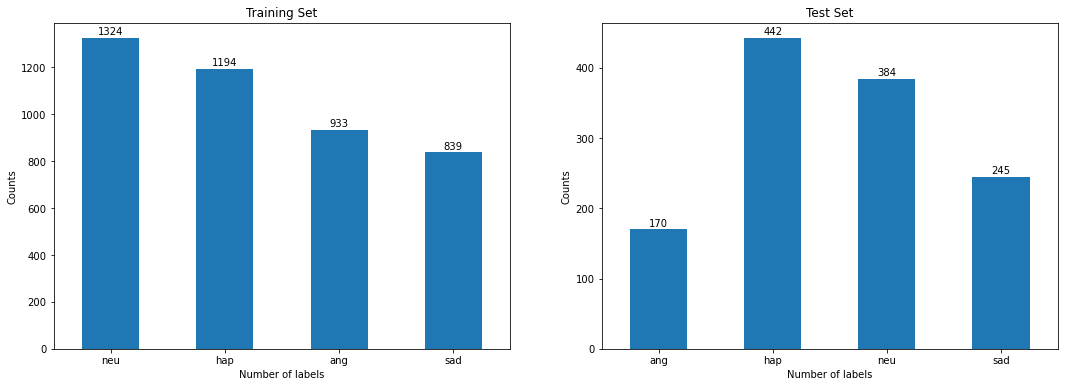

In [7]:
plt.figure(figsize=(18,6))

plt.subplot(121)
ax1 = Train_df['emotion'].sort_index().value_counts().plot(kind='bar')
plt.xlabel('Number of labels')
plt.ylabel('Counts')
plt.xticks(rotation=0)
plt.title('Training Set')

for p in ax1.patches:
    ax1.annotate(str(p.get_height()), 
                (p.get_x() + p.get_width()/2., p.get_height() * 1.005), 
                ha='center',
                va='center',
                xytext=(0,5), 
                textcoords='offset points')

plt.subplot(122)
ax2 = Test_df['emotion'].value_counts().sort_index().plot(kind='bar', )
plt.xlabel('Number of labels')
plt.ylabel('Counts')
plt.xticks(rotation=0)
plt.title('Test Set')

for p in ax2.patches:
    ax2.annotate(str(p.get_height()), 
                (p.get_x() + p.get_width()/2., p.get_height() * 1.005), 
                ha='center',
                va='center',
                xytext=(0,5), 
                textcoords='offset points')

    
plt.show()

In [8]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(Train_df['emotion'])
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(label_mapping)

{'ang': 0, 'hap': 1, 'neu': 2, 'sad': 3}


In [9]:
label_column = pd.Index(['ang', 'hap', 'neu','sad'])

In [10]:
for col in tqdm(label_column):
    Train_df[col] = 0
    Test_df[col] = 0
    
print(Train_df.shape, Test_df.shape)

100%|██████████| 4/4 [00:00<00:00, 795.43it/s]

(4290, 6) (1241, 6)


In [11]:
Train_df.head()

,emotion,fname,ang,hap,neu,sad
0,neu,Ses01F_impro04_F000.opus,0,0,0,0
1,neu,Ses01F_impro04_F001.opus,0,0,0,0
5,neu,Ses01F_impro04_F005.opus,0,0,0,0
6,neu,Ses01F_impro04_F006.opus,0,0,0,0
9,neu,Ses01F_impro04_F009.opus,0,0,0,0


In [12]:
Train_df_labels = split_and_label(Train_df['emotion'])
Test_df_labels = split_and_label(Test_df['emotion'])

In [13]:
Train_df[label_column] = Train_df_labels
Test_df[label_column] = Test_df_labels

In [14]:
Train_df['num_labels'] = Train_df[label_column].sum(axis=1)
Test_df['num_labels'] = Test_df[label_column].sum(axis=1)

In [15]:
Test_df

,emotion,fname,ang,hap,neu,sad,num_labels
0,hap,Ses05M_impro07_F000.opus,0.0,1.0,0.0,0.0,1.0
1,hap,Ses05M_impro07_F001.opus,0.0,1.0,0.0,0.0,1.0
3,hap,Ses05M_impro07_F003.opus,0.0,1.0,0.0,0.0,1.0
4,hap,Ses05M_impro07_F004.opus,0.0,1.0,0.0,0.0,1.0
5,hap,Ses05M_impro07_F005.opus,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...
2162,sad,Ses05M_impro02_M025.opus,0.0,0.0,0.0,1.0,1.0
2164,sad,Ses05M_impro02_M027.opus,0.0,0.0,0.0,1.0,1.0
2165,sad,Ses05M_impro02_M028.opus,0.0,0.0,0.0,1.0,1.0
2166,sad,Ses05M_impro02_M029.opus,0.0,0.0,0.0,1.0,1.0


In [16]:
# Special thanks to https://github.com/makinacorpus/easydict/blob/master/easydict/__init__.py

class EasyDict(dict):

    def __init__(self, d=None, **kwargs):
        if d is None:
            d = {}
        if kwargs:
            d.update(**kwargs)
        for k, v in d.items():
            setattr(self, k, v)
        # Class attributes
        for k in self.__class__.__dict__.keys():
            if not (k.startswith('__') and k.endswith('__')) and not k in ('update', 'pop'):
                setattr(self, k, getattr(self, k))

    def __setattr__(self, name, value):
        if isinstance(value, (list, tuple)):
            value = [self.__class__(x)
                     if isinstance(x, dict) else x for x in value]
        elif isinstance(value, dict) and not isinstance(value, self.__class__):
            value = self.__class__(value)
        super(EasyDict, self).__setattr__(name, value)
        super(EasyDict, self).__setitem__(name, value)

    __setitem__ = __setattr__

    def update(self, e=None, **f):
        d = e or dict()
        d.update(f)
        for k in d:
            setattr(self, k, d[k])

    def pop(self, k, d=None):
        delattr(self, k)
        return super(EasyDict, self).pop(k, d)

In [17]:
conf = EasyDict()
conf.sampling_rate = 44100
conf.duration = 5
conf.hop_length = 347 # to make time steps 128
conf.fmin = 20
conf.fmax = conf.sampling_rate // 2
conf.n_mels = 128
conf.n_fft = conf.n_mels * 20

conf.samples = conf.sampling_rate * conf.duration

Train_path = '../input/iemocap-audio-files-compressed/Train/Train/'
Test_path = '../input/iemocap-audio-files-compressed/Compressed_audio/Compressed_audio/IEMOCAP_Compressed_br8_fs20/Session5/opus/'


In [18]:
def read_audio(conf, pathname, trim_long_data):
    y, sr = librosa.load(pathname, sr=conf.sampling_rate)
    # trim silence
    if 0 < len(y): # workaround: 0 length causes error
        y, _ = librosa.effects.trim(y) # trim, top_db=default(60)
    # make it unified length to conf.samples
    if len(y) > conf.samples: # long enough
        if trim_long_data:
            y = y[0:0+conf.samples]
    else: # pad blank
        padding = conf.samples - len(y)    # add padding at both ends
        offset = padding // 2
        y = np.pad(y, (offset, conf.samples - len(y) - offset), 'constant')
    return y

def audio_to_melspectrogram(conf, audio):
    spectrogram = librosa.feature.melspectrogram(audio, 
                                                 sr=conf.sampling_rate,
                                                 n_mels=conf.n_mels,
                                                 hop_length=conf.hop_length,
                                                 n_fft=conf.n_fft,
                                                 fmin=conf.fmin,
                                                 fmax=conf.fmax)
    spectrogram = librosa.power_to_db(spectrogram)
    spectrogram = spectrogram.astype(np.float32)
    return spectrogram

def read_as_melspectrogram(conf, pathname, trim_long_data, debug_display=False):
    x = read_audio(conf, pathname, trim_long_data)
    mels = audio_to_melspectrogram(conf, x)
    if debug_display:
        IPython.display.display(IPython.display.Audio(x, rate=conf.sampling_rate))
        show_melspectrogram(conf, mels)
    return mels

def convert_wav_to_image(df, source):
    X = []
    for i, row in tqdm_notebook(df.iterrows()):
        try:
            x = read_as_melspectrogram(conf, f'{source[0]}/{str(row.fname)}', trim_long_data=True)
        except:
            x = read_as_melspectrogram(conf, f'{source[1]}/{str(row.fname)}', trim_long_data=True)

        #x_color = mono_to_color(x)
        X.append(x.transpose())
        #df.loc[i, 'length'] = x.shape[1]
    return X

In [19]:
%%time

#X = np.array(convert_wav_to_image(train, source=[train_curated_path, train_noisy_path]))
X = np.array(convert_wav_to_image(Train_df, source=[Train_path]))


CPU times: user 17min 22s, sys: 4min 8s, total: 21min 31s
Wall time: 28min 57s


In [20]:
X_test = np.array(convert_wav_to_image(Test_df, source=[Test_path]))

In [21]:
Y_train = Train_df[label_column].values
Y_test = Test_df[label_column].values

In [22]:
X.shape

(4290, 636, 128)

In [32]:
import keras
from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.layers import Embedding, Input, Dense,GRU,LSTM,concatenate, Bidirectional, SpatialDropout1D, Conv1D, GlobalAveragePooling1D, GlobalMaxPooling1D, Dropout
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

In [33]:
class Attention(keras.layers.Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape = (input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight(shape = (input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

In [39]:
sequence_input = Input(shape=(636,128), dtype='float32')
x = LSTM(256, return_sequences=True)(sequence_input) 
att = Attention(636)(x)
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x) 

x = concatenate([att, avg_pool, max_pool])

preds = Dense(4, activation='softmax')(x)

model = Model(sequence_input, preds)
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 636, 128)]   0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 636, 256)     394240      input_4[0][0]                    
__________________________________________________________________________________________________
attention_2 (Attention)         (None, 256)          892         lstm_1[0][0]                     
__________________________________________________________________________________________________
global_average_pooling1d_2 (Glo (None, 256)          0           lstm_1[0][0]                     
_______________________________________________________________________________________

In [40]:
model.compile(loss='categorical_crossentropy',optimizer=Adam(0.005),metrics=['accuracy'])

In [41]:
assert len(X) == len(Y_train)
assert len(X_test) == len(Y_test)

In [42]:
#es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=3)

In [43]:
model.fit(np.array(X),
          Y_train,
          batch_size=1024,
          epochs=100,
          validation_data=(np.array(X_test), Y_test),
          )

Epoch 1/100
5/5 [==============================] - 3s 595ms/step - loss: 2.2373 - accuracy: 0.2641 - val_loss: 1.3301 - val_accuracy: 0.3400
Epoch 2/100
5/5 [==============================] - 2s 455ms/step - loss: 1.4590 - accuracy: 0.3387 - val_loss: 1.2995 - val_accuracy: 0.3255
Epoch 3/100
5/5 [==============================] - 2s 489ms/step - loss: 1.3100 - accuracy: 0.3837 - val_loss: 1.3281 - val_accuracy: 0.3006
Epoch 4/100
5/5 [==============================] - 2s 454ms/step - loss: 1.2803 - accuracy: 0.3858 - val_loss: 1.2639 - val_accuracy: 0.3570
Epoch 5/100
5/5 [==============================] - 2s 487ms/step - loss: 1.2436 - accuracy: 0.4016 - val_loss: 1.2246 - val_accuracy: 0.3956
Epoch 6/100
5/5 [==============================] - 2s 477ms/step - loss: 1.2036 - accuracy: 0.4156 - val_loss: 1.2099 - val_accuracy: 0.4367
Epoch 7/100
5/5 [==============================] - 3s 503ms/step - loss: 1.1625 - accuracy: 0.4583 - val_loss: 1.1826 - val_accuracy: 0.4271
Epoch 8/100
5

Epoch 59/100
5/5 [==============================] - 2s 463ms/step - loss: 1.0533 - accuracy: 0.5231 - val_loss: 1.1134 - val_accuracy: 0.4899
Epoch 60/100
5/5 [==============================] - 2s 499ms/step - loss: 1.0639 - accuracy: 0.4970 - val_loss: 1.1641 - val_accuracy: 0.4384
Epoch 61/100
5/5 [==============================] - 2s 452ms/step - loss: 1.0492 - accuracy: 0.5287 - val_loss: 1.1633 - val_accuracy: 0.4416
Epoch 62/100
5/5 [==============================] - 3s 514ms/step - loss: 1.0447 - accuracy: 0.5298 - val_loss: 1.1268 - val_accuracy: 0.4569
Epoch 63/100
5/5 [==============================] - 2s 452ms/step - loss: 1.0449 - accuracy: 0.5256 - val_loss: 1.1643 - val_accuracy: 0.4327
Epoch 64/100
5/5 [==============================] - 3s 504ms/step - loss: 1.0399 - accuracy: 0.5249 - val_loss: 1.1304 - val_accuracy: 0.4529
Epoch 65/100
5/5 [==============================] - 2s 476ms/step - loss: 1.0506 - accuracy: 0.5159 - val_loss: 1.1511 - val_accuracy: 0.4569
Epoch 

In [45]:
y_train_pred = model.predict(np.array(X))
y_val_pred = model.predict(np.array(X_test))

In [46]:
y_train_pred

array([[0.1633101 , 0.42226124, 0.38830793, 0.02612071],
       [0.27129006, 0.4857704 , 0.225874  , 0.01706556],
       [0.02690162, 0.13753916, 0.38928825, 0.44627097],
       ...,
       [0.01940487, 0.10332402, 0.21386278, 0.6634084 ],
       [0.51191163, 0.4210088 , 0.05173885, 0.01534076],
       [0.22189067, 0.44212374, 0.30239627, 0.03358935]], dtype=float32)

In [ ]:
y_train_pred = model.predict(np.array(X))
y_test_pred = model.predict(np.array(X_test))

In [50]:
preds=y_val_pred.argmax(axis=1)

print(preds)

[2 1 1 ... 1 1 1]


In [53]:
preds = preds.astype(int).flatten()
preds = (le.inverse_transform((preds)))
preds = pd.DataFrame({'predictedvalues': preds})

# Actual labels
actual=Y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (le.inverse_transform((actual)))
actual = pd.DataFrame({'actualvalues': actual})

# Lets combined both of them into a single dataframe
finaldf = actual.join(preds)

# Write out the predictions to disk
finaldf.to_csv('Predictions.csv', index=False)
print(finaldf.groupby('predictedvalues').count())


                 actualvalues
predictedvalues              
ang                        77
hap                       429
neu                       421
sad                       314


In [54]:

def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
finaldf = pd.read_csv("./Predictions.csv")
classes = finaldf.actualvalues.unique()
classes.sort()    
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
# Confusion matrix 
c = confusion_matrix(finaldf.actualvalues, finaldf.predictedvalues)
print(accuracy_score(finaldf.actualvalues, finaldf.predictedvalues))
plt.show(print_confusion_matrix(c, class_names = classes))